In [1]:
# Gurobi for optimization
from gurobipy import GRB, Model, quicksum
import gurobipy as gp

# Pandas for data manipulation
import pandas as pd

# Numpy for numerical operations
import numpy as np

# Matplotlib for visualization
import matplotlib.pyplot as plt

# Datetime for handling time-related data
import datetime

# Pickle for saving/loading objects (optional, based on need)
import pickle


In [2]:
# Seed for reproducibility
np.random.seed(46)


# Define basic parameters for new flights
num_original_flights = 50
num_new_flights = 50
total_flights = num_original_flights + num_new_flights

# Generate flight IDs for 100 flights
flight_ids = [f"F{i:02d}" for i in range(1, total_flights + 1)]

arrival_times = [
        '09:00', '08:30', '09:00', '08:30', '08:15', '07:30', '10:15', '10:00', '10:25', '10:40',
        '11:00', '11:00', '11:15', '11:30', '11:30', '12:00', '11:45', '11:50', '11:55', '12:10',
        '12:45', '12:05', '12:10', '12:20', '12:20', '12:20', '12:30', '12:25', '12:40', '12:55',
        '12:50', '12:00', '13:00', '13:10', '14:25', '14:30', '14:00', '14:55', '15:00', '19:55',
        '18:30', '19:30', '18:55', '21:00', '20:10', '20:00', '22:30', '21:25', '21:30', '22:15'
    ]
departure_times = [
        '09:50', '09:10', '09:50', '10:20', '09:00', '08:50', '11:20', '10:50', '11:55', '11:35',
        '12:35', '12:25', '12:15', '12:20', '12:40', '13:55', '13:40', '12:45', '12:55', '14:00',
        '14:30', '13:00', '13:30', '13:20', '13:40', '13:30', '14:10', '14:10', '14:40', '13:40',
        '14:30', '12:55', '14:25', '14:45', '16:10', '15:20', '15:20', '16:00', '15:50', '21:25',
        '19:25', '20:50', '19:55', '22:55', '22:00', '21:15', '23:25', '23:15', '22:45', '23:10'
    ]
passenger_numbers = [
        140, 138, 340, 293, 252, 105, 130, 166, 191, 178,
        293, 166, 255, 183, 176, 220, 173, 145, 118, 153,
        256, 104, 269, 140, 142, 129, 190, 142, 163, 185,
        258, 133, 156, 120, 193, 300, 104, 219, 239, 111,
        166, 242, 167, 278, 195, 144, 219, 253, 158, 276
    ]
flight_types = [
        'Domestic', 'Domestic', 'International', 'International', 'International',
        'Domestic', 'Domestic', 'Domestic', 'International', 'Domestic',
        'International', 'Domestic', 'International', 'International', 'Domestic',
        'International', 'Domestic', 'Domestic', 'Domestic', 'Domestic',
        'International', 'Domestic', 'International', 'Domestic', 'Domestic',
        'Domestic', 'International', 'Domestic', 'Domestic', 'International',
        'International', 'Domestic', 'Domestic', 'Domestic', 'International',
        'International', 'Domestic', 'International', 'International', 'Domestic',
        'Domestic', 'International', 'Domestic', 'International', 'International',
        'Domestic', 'International', 'International', 'Domestic', 'International'
    ]

# Helper function to generate random times within a certain range
def generate_random_time(start_hour, end_hour):
    """Generate a random time string between start_hour and end_hour."""
    hour = np.random.randint(start_hour, end_hour)
    minute = np.random.choice([0, 15, 30, 45])
    return f"{hour:02d}:{minute:02d}"

# Function to ensure departure is logically after arrival and before 24:00
def ensure_logical_times(num_flights):
    max_arrival_minute = 23.5 * 60  # 23:30 in minutes
    max_departure_minute = 24 * 60  # 24:00 in minutes
    arrival_times = []
    departure_times = []
    for _ in range(num_flights):
        arrival = generate_random_time(8, 23)  # Allow arrivals up to 23:30
        arrival_minutes = int(arrival.split(':')[0]) * 60 + int(arrival.split(':')[1])
        # Ensure arrival time does not exceed 23:30
        if arrival_minutes > max_arrival_minute:
            arrival_minutes = max_arrival_minute
            arrival = f"{arrival_minutes // 60:02d}:{arrival_minutes % 60:02d}"
        
        # Define the latest departure time as the minimum between the flight's max duration and 24:00
        latest_departure_time = min(arrival_minutes + 360, max_departure_minute)
        departure_minutes = np.random.randint(arrival_minutes + 30, latest_departure_time + 1)
        departure = f"{departure_minutes // 60:02d}:{departure_minutes % 60:02d}"
        arrival_times.append(arrival)
        departure_times.append(departure)
    return arrival_times, departure_times

# Generate additional data for new flights
new_types = np.random.choice(['Domestic', 'International'], num_new_flights)
new_passengers = np.random.randint(100, 350, num_new_flights)
new_arrival_times, new_departure_times = ensure_logical_times(num_new_flights)

# Combine existing and new flight data
flight_types = np.concatenate((flight_types, new_types))
passenger_numbers = np.concatenate((passenger_numbers, new_passengers))
arrival_times = np.concatenate((arrival_times, new_arrival_times))
departure_times = np.concatenate((departure_times, new_departure_times))

# Convert times to minutes since midnight for consistency with previous code
def time_to_minutes(t):
    h, m = map(int, t.split(':'))
    return h * 60 + m

arrival_times = [time_to_minutes(t) for t in arrival_times]
departure_times = [time_to_minutes(t) for t in departure_times]

flight_data = pd.DataFrame({
    'flight_id': flight_ids,
    'arrival_time': arrival_times,
    'departure_time': departure_times,
    'passenger_number': passenger_numbers,
    'flight_type': flight_types
})

# Gate IDs
gate_ids = [f"Gate {i}" for i in range(1, 26)]
gate_types = ['Domestic' if i in [1, 2, 5, 7, 8, 10, 12, 13, 15, 16, 19, 22, 23, 25] else 'International' for i in range(1, 26)]

gate_data = pd.DataFrame({
    'gate_id': gate_ids,
    'gate_type': gate_types
})

# Manually entered distances from the provided matrix
distances = [
    [0, 2, 4, 6, 8, 8, 6, 6, 8, 10, 10, 8, 10, 12, 12, 18, 20, 22, 20, 18, 18, 20, 22, 20, 18],
    [2, 0, 2, 4, 6, 6, 4, 4, 6, 8, 8, 6, 8, 10, 10, 16, 18, 20, 18, 16, 16, 18, 20, 18, 16],
    [4, 2, 0, 2, 4, 4, 2, 2, 4, 6, 6, 4, 6, 8, 8, 14, 16, 18, 16, 14, 14, 16, 18, 16, 14],
    [6, 4, 2, 0, 2, 2, 0, 2, 4, 6, 6, 4, 6, 8, 8, 14, 16, 18, 16, 14, 14, 16, 18, 16, 14],
    [8, 6, 4, 2, 0, 0, 2, 4, 6, 8, 8, 6, 8, 10, 10, 16, 18, 20, 18, 16, 16, 18, 20, 18, 16],
    [8, 6, 4, 2, 0, 0, 2, 4, 6, 8, 8, 6, 8, 10, 10, 16, 18, 20, 18, 16, 16, 18, 20, 18, 16],
    [6, 4, 2, 0, 2, 2, 0, 2, 4, 6, 6, 4, 6, 8, 8, 14, 16, 18, 16, 14, 14, 16, 18, 16, 14],
    [6, 4, 2, 2, 4, 4, 2, 0, 2, 4, 4, 2, 4, 6, 6, 12, 14, 16, 14, 12, 12, 14, 16, 14, 12],
    [8, 6, 4, 4, 6, 6, 4, 2, 0, 2, 2, 0, 2, 4, 4, 14, 16, 18, 16, 14, 14, 16, 18, 16, 14],
    [10, 8, 6, 6, 8, 8, 6, 4, 2, 0, 0, 2, 4, 6, 6, 16, 18, 20, 18, 16, 16, 18, 20, 18, 16],
    [10, 8, 6, 6, 8, 8, 6, 4, 2, 0, 0, 2, 4, 6, 6, 16, 18, 20, 18, 16, 16, 18, 20, 18, 16],
    [8, 6, 4, 4, 6, 6, 4, 2, 0, 2, 2, 0, 2, 4, 4, 14, 16, 18, 16, 14, 14, 16, 18, 16, 14],
    [10, 8, 6, 6, 8, 8, 6, 4, 2, 4, 4, 2, 0, 2, 2, 16, 18, 20, 18, 16, 16, 18, 20, 18, 16],
    [12, 10, 8, 8, 10, 10, 8, 6, 4, 6, 6, 4, 2, 0, 2, 18, 20, 22, 20, 18, 18, 20, 22, 20, 18],
    [12, 10, 8, 8, 10, 10, 8, 6, 4, 6, 6, 4, 2, 2, 0, 18, 20, 22, 20, 18, 18, 20, 22, 20, 18],
    [18, 16, 14, 14, 16, 16, 14, 12, 14, 16, 16, 14, 16, 18, 18, 0, 2, 4, 2, 0, 0, 2, 4, 2, 0],
    [20, 18, 16, 16, 18, 18, 16, 14, 16, 18, 18, 16, 18, 20, 20, 2, 0, 2, 0, 2, 2, 4, 6, 4, 2],
    [22, 20, 18, 18, 20, 20, 18, 16, 18, 20, 20, 18, 20, 22, 22, 4, 2, 0, 2, 4, 4, 6, 8, 6, 4],
    [20, 18, 16, 16, 18, 18, 16, 14, 16, 18, 18, 16, 18, 20, 20, 2, 0, 2, 0, 2, 2, 4, 6, 4, 2],
    [18, 16, 14, 14, 16, 16, 14, 12, 14, 16, 16, 14, 16, 18, 18, 0, 2, 4, 2, 0, 0, 2, 4, 2, 0],
    [18, 16, 14, 14, 16, 16, 14, 12, 14, 16, 16, 14, 16, 18, 18, 0, 2, 4, 2, 0, 0, 2, 4, 2, 0],
    [20, 18, 16, 16, 18, 18, 16, 14, 16, 18, 18, 16, 18, 20, 20, 2, 4, 6, 4, 2, 2, 0, 2, 0, 2],
    [22, 20, 18, 18, 20, 20, 18, 16, 18, 20, 20, 18, 20, 22, 22, 4, 6, 8, 6, 4, 4, 2, 0, 2, 4],
    [20, 18, 16, 16, 18, 18, 16, 14, 16, 18, 18, 16, 18, 20, 20, 2, 4, 6, 4, 2, 2, 0, 2, 0, 2],
    [18, 16, 14, 14, 16, 16, 14, 12, 14, 16, 16, 14, 16, 18, 18, 0, 2, 4, 2, 0, 0, 2, 4, 2, 0]
]

# Convert distances array to DataFrame for better readability
distance_df = pd.DataFrame(distances, index=gate_ids, columns=gate_ids)


# Distances to the exit
ed_k = [3 if i in [1, 2, 3, 8, 13, 14, 15] else 5 if i in [4, 7, 9, 12] else 7 if i in [5, 6, 10, 11] else 14 for i in range(1, 26)]

# Store number of flights and gates
num_flights = len(flight_data)
num_gates = len(gate_data)

# Generate transiting passengers data (p_ij) with constraints
p_ij = np.zeros((num_flights, num_flights), dtype=int)

for i in range(num_flights):
    max_transit_passengers = passenger_numbers[i] // 2  # Maximum of 50% of the total passengers
    remaining_passengers = max_transit_passengers
    transfer_flights = np.random.choice([x for x in range(num_flights) if x != i], 2, replace=False)  # Choose 2 different flights
    for j in transfer_flights:
        if remaining_passengers > 0:
            p_ij[i, j] = np.random.randint(0, min(50, remaining_passengers + 1))
            remaining_passengers -= p_ij[i, j]

# Second pass to ensure inflow constraints are met
for j in range(num_flights):
    total_inflow = sum(p_ij[i, j] for i in range(num_flights))
    if total_inflow > passenger_numbers[j]:
        excess_passengers = total_inflow - passenger_numbers[j]
        inflow_flights = [i for i in range(num_flights) if p_ij[i, j] > 0]
        
        while excess_passengers > 0 and inflow_flights:
            i = inflow_flights.pop()
            reduction = min(p_ij[i, j], excess_passengers)
            p_ij[i, j] -= reduction
            excess_passengers -= reduction

# Verify generated data
print("Flight Data:")
print(flight_data.head(num_flights))
#print(flight_data.iloc[50:101])
#print(flight_data.tail(50))

print("\nGate Data:")
print(gate_data.head(num_gates))

print("\nDistance Matrix (d_kl):")
print(distance_df)

print("\nDistance to Entrance/Exit (ed_k):")
print(pd.Series(ed_k, index=gate_ids))

print("\nTransiting Passengers (p_ij):")
print(pd.DataFrame(p_ij, index=flight_ids, columns=flight_ids).head(num_flights))


Flight Data:
   flight_id  arrival_time  departure_time  passenger_number    flight_type
0        F01           540             590               140       Domestic
1        F02           510             550               138       Domestic
2        F03           540             590               340  International
3        F04           510             620               293  International
4        F05           495             540               252  International
..       ...           ...             ...               ...            ...
95       F96          1260            1399               166       Domestic
96       F97          1245            1282               329  International
97       F98          1050            1258               253  International
98       F99          1185            1423               292  International
99      F100           615             935               153  International

[100 rows x 5 columns]

Gate Data:
    gate_id      gate_type
0    Gate 1 

### Model Explanation

The objective of the FC formulation is to minimize the total walking distance of passengers at the airport, considering both transfer passengers and non-transfer passengers. The model includes the following key components:

- **Parameters**:
  - `num_flights`: Number of flights
  - `num_gates`: Number of gates
  - `arrival_times`: Arrival times of flights
  - `departure_times`: Departure times of flights
  - `passenger_numbers`: Number of passengers per flight
  - `flight_types`: Type of flight (domestic/international)
  - `gate_types`: Type of gate (domestic/international)
  - `distances`: Distance matrix between gates

- **Decision Variables**:
  - `x[i, k]`: Binary variable, 1 if flight \(i\) is assigned to gate \(k\), 0 otherwise
  - `w[i, k, l]`: Continuous variable representing the number of passengers from flight \(i\) through gate \(k\) to gate \(l\)

- **Objective Function**:
  - Minimize the total walking distance of passengers.

- **Constraints**:
  - Each flight must be assigned to exactly one gate.
  - Gates cannot be double-booked.
  - Flow balance constraints for transfer passengers.


In [3]:
# Initialize the Gurobi model
model = Model("FC_Formulation")

# Distance penalty for the apron
apron_distance_penalty = 30

# Distance matrices
d_kl = np.zeros((num_gates + 1, num_gates + 1))
d_kl[:num_gates, :num_gates] = distance_df.values
d_kl[num_gates, :] = apron_distance_penalty  # Distance from apron to all gates
d_kl[:, num_gates] = apron_distance_penalty  # Distance from all gates to apron
d_kl[num_gates, num_gates] = apron_distance_penalty  # Distance from apron to itself

# Distance to/from exit for each gate (including apron)
ed_k = np.append(ed_k, apron_distance_penalty)  # Append apron distance to exit

print(d_kl,ed_k)
# Passengers data
e_i = flight_data['passenger_number'].values - np.sum(p_ij, axis=1)
f_i = flight_data['passenger_number'].values - np.sum(p_ij, axis=0)

# Aircraft type (domestic/international)
g_i = flight_data['flight_type'].apply(lambda x: 'D' if x == 'Domestic' else 'I').values

# Sets of domestic and international gates
K_D = [k for k, t in zip(range(num_gates), gate_types) if t == 'Domestic']
K_I = [k for k, t in zip(range(num_gates), gate_types) if t == 'International']
K_D.append(num_gates)  # Add apron to domestic gates
K_I.append(num_gates)  # Add apron to international gates

# Number of gates
m = num_gates

# Generating overlap sets for all time steps
def generate_overlap_sets(flight_data):
    # Initialize dictionaries to hold overlap sets
    I_Dt = []
    I_It = []
    T_D = {}
    T_I = {}
    
    # Iterate through each minute of the day
    for t in range(1440):
        domestic_overlaps = set()
        international_overlaps = set()
        
        # Check for overlapping flights at time t
        for i, flight in flight_data.iterrows():
            if flight['arrival_time'] <= t < flight['departure_time']:
                if flight['flight_type'] == 'Domestic':
                    domestic_overlaps.add(flight['flight_id'])
                else:
                    international_overlaps.add(flight['flight_id'])
        
        if domestic_overlaps:
            I_Dt.append(domestic_overlaps)
        if international_overlaps:
            I_It.append(international_overlaps)
    
    # Convert I_Dt and I_It to T_D and T_I
    for idx, overlap_set in enumerate(I_Dt):
        if overlap_set:
            T_D[f"TD{idx+1}"] = overlap_set
            
    for idx, overlap_set in enumerate(I_It):
        if overlap_set:
            T_I[f"TI{idx+1}"] = overlap_set
    
    return T_D, T_I

# Generate overlap sets
T_D, T_I = generate_overlap_sets(flight_data)

# Print overlap sets
print("Overlap Sets for Domestic Flights (T_D):")
for key, value in T_D.items():
    print(f"{key}: {value}")

print("\nOverlap Sets for International Flights (T_I):")
for key, value in T_I.items():
    print(f"{key}: {value}")

# Calculate N_A_star
def calculate_N_A_star(T_D, T_I, K_D, K_I):
    N_A_star = 0
    for overlap_set in T_D.values():
        if len(overlap_set) > len(K_D):
            N_A_star += len(overlap_set) - len(K_D) + 1
            print(f"Domestic Overlap Set: {overlap_set}, Excess: {len(overlap_set) - len(K_D)+1}")
    for overlap_set in T_I.values():
        if len(overlap_set) > len(K_I):
            N_A_star += len(overlap_set) - len(K_I) + 1
            print(f"International Overlap Set: {overlap_set}, Excess: {len(overlap_set) - len(K_I)+1}")
    return N_A_star

N_A_star = calculate_N_A_star(T_D, T_I, K_D, K_I)
print("\nN_A_star:", N_A_star)

# Define function to calculate NA*
def calculate_NA_star(flight_data, num_gates):
    # Create a list to hold the number of aircraft at each minute
    time_slots = [0] * 1440  # There are 1440 minutes in a day

    # Populate the list with the number of overlapping aircraft at each minute
    for index, flight in flight_data.iterrows():
        for t in range(flight['arrival_time'], flight['departure_time']):
            time_slots[t] += 1
    
    # Calculate the maximum number of aircraft exceeding the available gates
    max_excess_aircraft = max([max(0, count - num_gates) for count in time_slots])
    
    return max_excess_aircraft

NA_star = calculate_NA_star(flight_data, num_gates)
print("NA*:", NA_star)

# Decision Variables
x = model.addVars(num_flights, num_gates + 1, vtype=GRB.BINARY, name="x")
w = model.addVars(num_flights, num_gates + 1, num_gates + 1, vtype=GRB.CONTINUOUS, name="w")

# Verify variables
print("Decision variables defined.")


Set parameter Username
Academic license - for non-commercial use only - expires 2025-02-19


[[ 0.  2.  4.  6.  8.  8.  6.  6.  8. 10. 10.  8. 10. 12. 12. 18. 20. 22.
  20. 18. 18. 20. 22. 20. 18. 30.]
 [ 2.  0.  2.  4.  6.  6.  4.  4.  6.  8.  8.  6.  8. 10. 10. 16. 18. 20.
  18. 16. 16. 18. 20. 18. 16. 30.]
 [ 4.  2.  0.  2.  4.  4.  2.  2.  4.  6.  6.  4.  6.  8.  8. 14. 16. 18.
  16. 14. 14. 16. 18. 16. 14. 30.]
 [ 6.  4.  2.  0.  2.  2.  0.  2.  4.  6.  6.  4.  6.  8.  8. 14. 16. 18.
  16. 14. 14. 16. 18. 16. 14. 30.]
 [ 8.  6.  4.  2.  0.  0.  2.  4.  6.  8.  8.  6.  8. 10. 10. 16. 18. 20.
  18. 16. 16. 18. 20. 18. 16. 30.]
 [ 8.  6.  4.  2.  0.  0.  2.  4.  6.  8.  8.  6.  8. 10. 10. 16. 18. 20.
  18. 16. 16. 18. 20. 18. 16. 30.]
 [ 6.  4.  2.  0.  2.  2.  0.  2.  4.  6.  6.  4.  6.  8.  8. 14. 16. 18.
  16. 14. 14. 16. 18. 16. 14. 30.]
 [ 6.  4.  2.  2.  4.  4.  2.  0.  2.  4.  4.  2.  4.  6.  6. 12. 14. 16.
  14. 12. 12. 14. 16. 14. 12. 30.]
 [ 8.  6.  4.  4.  6.  6.  4.  2.  0.  2.  2.  0.  2.  4.  4. 14. 16. 18.
  16. 14. 14. 16. 18. 16. 14. 30.]
 [10.  8.  6.  6.  

In [4]:
# Objective function components\n",
objective = quicksum(d_kl[k, l] * w[i, k, l] for i in range(num_flights) for k in range(num_gates + 1) for l in range(num_gates + 1)) + \
            quicksum((e_i[i] + f_i[i]) * ed_k[k] * x[i, k] for i in range(num_flights) for k in range(num_gates + 1))

model.setObjective(objective, GRB.MINIMIZE)

# Verify objective
print("Objective function defined.")

Objective function defined.


In [5]:
# Constraint 3: Assign each aircraft to exactly one gate
for i in range(num_flights):
    if g_i[i] == 'D':
        model.addConstr(quicksum(x[i, k] for k in K_D) == 1, name=f"Assign_Domestic_{i}")
    else:
        model.addConstr(quicksum(x[i, k] for k in K_I) == 1, name=f"Assign_International_{i}")

# Add Constraints (4) and (5): At most one aircraft can be assigned to a fixed gate during a certain time interval
# Constraint (4) for domestic flights (excluding apron)
for t, I_Dt in T_D.items():
    for k in K_D[:-1]:  # Exclude the apron
        model.addConstr(quicksum(x[flight_ids.index(flight), k] for flight in I_Dt) <= 1, name=f"MaxOneAircraft_Domestic_{t}_Gate{k}")

# Constraint (5) for international flights (excluding apron)
for t, I_It in T_I.items():
    for k in K_I[:-1]:  # Exclude the apron
        model.addConstr(quicksum(x[flight_ids.index(flight), k] for flight in I_It) <= 1, name=f"MaxOneAircraft_International_{t}_Gate{k}")

# # Constraint 6: Minimum apron assignments
# model.addConstr(quicksum(x[i, num_gates] for i in range(num_flights)) <= 5, name="min_apron_assignments")

# Constraint (10): Passenger flow balance constraints (outbound)
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I  # Select the appropriate gate set
    for k in gate_set:
        model.addConstr(
            quicksum(w[i, k, l] for l in range(num_gates + 1)) == x[i, k] * sum(p_ij[i, j] for j in range(num_flights)),
            name=f"FlowBalance_{i}_{k}"
        )

# Constraint 11: Passenger flow balance constraints (inbound)
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I  # Select the appropriate gate set
    for k in range(num_gates + 1):  # Iterate over all gates including the apron
        model.addConstr(
            quicksum(w[i, l, k] for l in gate_set) == 
            quicksum(p_ij[i, j] * x[j, k] for j in range(num_flights)),
            name=f"PassengerFlow_{i}_{k}"
        )

# Constraint 12: Non-negativity of flow variables
for i in range(num_flights):
    gate_set = K_D if g_i[i] == 'D' else K_I  # Select the appropriate gate set
    for k in gate_set:
        for l in range(num_gates + 1):  # Iterate over all gates including the apron
            model.addConstr(
                w[i, k, l] >= 0,
                name=f"NonNegativeFlow_{i}_{k}_{l}"
            )

# Constraint (13): Ensure that overlapping domestic aircraft are assigned to the apron
for t, I_Dt in T_D.items():
    if len(I_Dt) > len(K_D) - 1:  # K_D includes the apron, so len(K_D) - 1 is the number of fixed gates
        model.addConstr(
            quicksum(x[flight_ids.index(flight), num_gates] for flight in I_Dt) >= len(I_Dt) - (len(K_D) - 1),
            name=f"ApronAssignment_Domestic_{t}"
        )

# Constraint (14): Ensure that overlapping international aircraft are assigned to the apron
for t, I_It in T_I.items():
    if len(I_It) > len(K_I) - 1:  # K_I includes the apron, so len(K_I) - 1 is the number of fixed gates
        model.addConstr(
            quicksum(x[flight_ids.index(flight), num_gates] for flight in I_It) >= len(I_It) - (len(K_I) - 1),
            name=f"ApronAssignment_International_{t}"
        )

# Verify constraints
print("Constraints defined.")


Constraints defined.


In [ ]:
# Optimize model
model.optimize()

# Print results
if model.status == GRB.OPTIMAL:
    # Print flight assignments to gates
    for i in range(num_flights):
        for k in range(num_gates + 1):
            if x[i, k].X > 0.5:  # Check if the flight is assigned to the gate
                gate = 'Apron' if k == num_gates else gate_ids[k]
                print(f"Flight {flight_data.loc[i, 'flight_id']} is assigned to {gate}")
    
    # Print the flow of passengers between gates and to the exit
    print("\nPassenger Flow Between Gates and to the Exit:")
    for i in range(num_flights):
        for k in range(num_gates + 1):
            gate_from = 'Apron' if k == num_gates else gate_ids[k]
            total_transfer_passengers = 0
            # Flow to other gates
            for l in range(num_gates + 1):
                if w[i, k, l].X > 0:  # Only print non-zero flows
                    gate_to = 'Apron' if l == num_gates else gate_ids[l]
                    print(f"Flow from Flight {flight_data.loc[i, 'flight_id']} at {gate_from} to {gate_to}: {w[i, k, l].X}")
                    total_transfer_passengers += w[i, k, l].X
            # Flow to exit
            if x[i, k].X > 0.5:
                passengers_to_exit = flight_data.loc[i, 'passenger_number'] - total_transfer_passengers
                if passengers_to_exit > 0:
                    print(f"Flow from Flight {flight_data.loc[i, 'flight_id']} at {gate_from} to Exit: {passengers_to_exit}")
else:
    print("No optimal solution found.")


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 63844 rows, 70200 columns and 263501 nonzeros
Model fingerprint: 0x60487eef
Variable types: 67600 continuous, 2600 integer (2600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [2e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 59168 rows and 32227 columns
Presolve time: 0.37s
Presolved: 4676 rows, 37973 columns, 84682 nonzeros
Variable types: 35607 continuous, 2366 integer (2366 binary)
Found heuristic solution: objective 1053656.0000
Found heuristic solution: objective 1040057.0000
Found heuristic solution: objective 376837.00000

Root relaxation: objective 2.166660e+05, 8970 iterations, 2.28 seconds (2.93 work units)

    Nodes    | 

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 63844 rows, 70200 columns and 263501 nonzeros
Model fingerprint: 0x9b5a2702
Variable types: 67600 continuous, 2600 integer (2600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [2e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolved: 4676 rows, 37973 columns, 84682 nonzeros

Continuing optimization...


Cutting planes:
  Gomory: 3
  Implied bound: 317
  Projected implied bound: 18
  MIR: 600
  Mixing: 1
  Flow cover: 1821
  Inf proof: 10
  RLT: 39
  Relax-and-lift: 122

Explored 134053 nodes (135251513 simplex iterations) in 0.13 seconds (0.05 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 222164 222256 222336 ... 

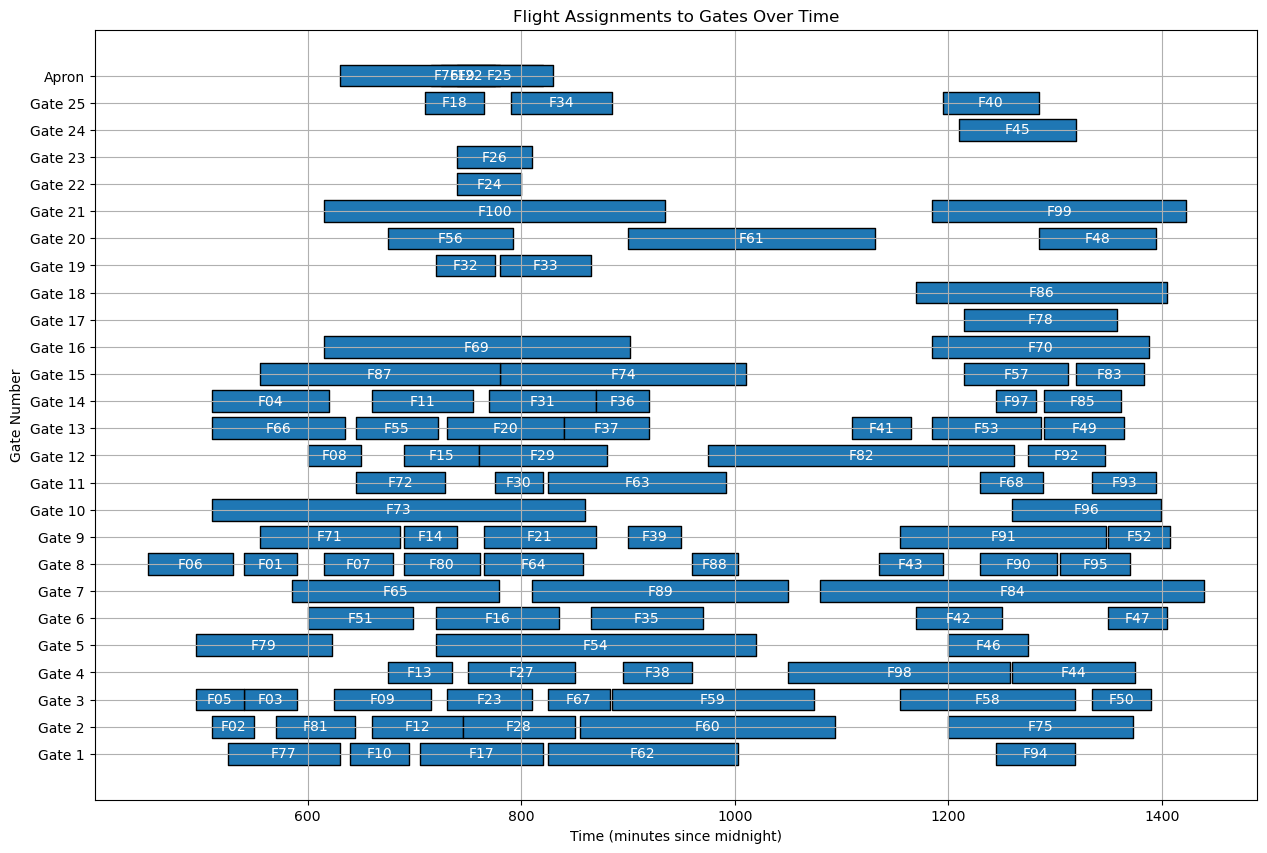

In [ ]:
# Optimize model
model.optimize()

# Create a dictionary to store flight assignments
flight_assignments = {}

# Collect flight assignments to gates
if model.status == GRB.OPTIMAL:
    for i in range(num_flights):
        for k in range(num_gates + 1):
            if x[i, k].X > 0.5:  # Check if the flight is assigned to the gate
                gate = 'Apron' if k == num_gates else gate_ids[k]
                flight_assignments[flight_data.loc[i, 'flight_id']] = {
                    'gate': gate,
                    'arrival_time': flight_data.loc[i, 'arrival_time'],
                    'departure_time': flight_data.loc[i, 'departure_time']
                }

    # Plot the flight assignments
    fig, ax = plt.subplots(figsize=(15, 10))

    for flight_id, info in flight_assignments.items():
        gate = info['gate']
        arrival_time = info['arrival_time']
        departure_time = info['departure_time']
        gate_num = gate_ids.index(gate) + 1 if gate != 'Apron' else num_gates + 1

        ax.broken_barh([(arrival_time, departure_time - arrival_time)], (gate_num - 0.4, 0.8),
                       facecolors=('tab:blue'), edgecolors=('black'))
        ax.text((arrival_time + departure_time) / 2, gate_num, flight_id,
                ha='center', va='center', color='white')

    # Set labels and title
    ax.set_xlabel('Time (minutes since midnight)')
    ax.set_ylabel('Gate Number')
    ax.set_title('Flight Assignments to Gates Over Time')
    ax.set_yticks(range(1, num_gates + 2))
    ax.set_yticklabels(gate_ids + ['Apron'])
    ax.grid(True)

    plt.show()
else:
    print("No optimal solution found.")


In [ ]:
# Optimize the model
model.optimize()

# Print results and verify constraints
if model.status == GRB.OPTIMAL:
    print("\nOptimal solution found. Verifying constraints...")

    constraints_met = True

    # Verifying Constraint 3: Each flight is assigned to exactly one gate
    all_flights_assigned_correctly = True
    for i in range(num_flights):
        gate_count = sum(x[i, k].X > 0.5 for k in range(num_gates + 1))
        if gate_count != 1:
            print(f"Constraint 3 violation: Flight {flight_data.loc[i, 'flight_id']} is assigned to {gate_count} gates.")
            all_flights_assigned_correctly = False
            constraints_met = False

    if all_flights_assigned_correctly:
        print("\nConstraint 3 is met: All flights are correctly assigned to exactly one gate or the apron.")

    # Verifying Constraint 4 for domestic flights
    domestic_violations = []
    for t, I_Dt in T_D.items():
        for k in K_D[:-1]:  # Exclude the apron
            assigned_flights = sum(x[flight_ids.index(flight), k].X > 0.5 for flight in I_Dt)
            if assigned_flights > 1:
                domestic_violations.append((t, k, assigned_flights))
                print(f"Constraint 4 violation: Time {t}, Gate {k} - {assigned_flights} domestic flights assigned.")
                constraints_met = False

    # Verifying Constraint 5 for international flights
    international_violations = []
    for t, I_It in T_I.items():
        for k in K_I[:-1]:  # Exclude the apron
            assigned_flights = sum(x[flight_ids.index(flight), k].X > 0.5 for flight in I_It)
            if assigned_flights > 1:
                international_violations.append((t, k, assigned_flights))
                print(f"Constraint 5 violation: Time {t}, Gate {k} - {assigned_flights} international flights assigned.")
                constraints_met = False

    if not domestic_violations and not international_violations:
        print("Constraints 4 and 5 are met: All gate assignments during time intervals are correct.")

    # Verifying Constraint 10 for outbound passenger flows
    outbound_violations = []
    for i in range(num_flights):
        gate_set = K_D if flight_data.loc[i, 'flight_type'] == 'Domestic' else K_I  # Adjusted to use flight_data
        for k in gate_set:
            expected_flow = sum(p_ij[i][j] for j in range(num_flights)) * x[i, k].X
            actual_flow = sum(w[i, k, l].X for l in range(num_gates + 1))
            if abs(actual_flow - expected_flow) > 1e-5:  # Allowing a small numerical tolerance
                outbound_violations.append((i, k, actual_flow, expected_flow))
                print(f"Constraint 10 violation: Outbound flow mismatch for Flight {flight_data.loc[i, 'flight_id']} at Gate {k}: Expected {expected_flow}, Actual {actual_flow}")
                constraints_met = False

    if not outbound_violations:
        print("Constraint 10 is met: Outbound passenger flows are correct.")

    # Verify Constraint 11 for inbound passenger flows
    inbound_violations = []
    for i in range(num_flights):
        gate_set = K_D if g_i[i] == 'D' else K_I
        for k in range(num_gates + 1):
            total_flow = sum(w[i, l, k].X for l in gate_set)
            expected_flow = sum(p_ij[i, j] * x[j, k].X for j in range(num_flights))
            if abs(total_flow - expected_flow) > 1e-5:  # Allowing a small numerical tolerance
                inbound_violations.append((i, k, total_flow, expected_flow))
                print(f"Constraint 11 violation: Inbound flow mismatch for Flight {flight_ids[i]} at Gate {k}: Expected {expected_flow}, Actual {total_flow}")
                constraints_met = False

    if not inbound_violations:
        print("Constraint 11 is met: Inbound passenger flows are correct.")

    # Verify Constraint 12: Non-negativity of flow variables
    non_negative = True
    for i in range(num_flights):
        gate_set = K_D if g_i[i] == 'D' else K_I
        for k in gate_set:
            for l in range(num_gates + 1):
                if w[i, k, l].X < 0:
                    print(f"Constraint 12 violation: Flight {flight_ids[i]}, Gate {k} to Gate {l}, Negative flow: {w[i, k, l].X}")
                    non_negative = False
                    constraints_met = False

    if non_negative:
        print("Constraint 12 is met: All flow variables are non-negative.")

    # Verify Constraint 13 for domestic flights
    domestic_constraint_13_met = True
    for t, I_Dt in T_D.items():
        if len(I_Dt) > len(K_D) - 1:
            apron_count = sum(x[flight_ids.index(flight), num_gates].X > 0.5 for flight in I_Dt)
            required_apron_count = len(I_Dt) - (len(K_D) - 1)
            if apron_count < required_apron_count:
                print(f"Constraint 13 violation: Time Interval {t}: {apron_count} domestic flights assigned to apron, required: {required_apron_count}")
                domestic_constraint_13_met = False
                constraints_met = False

    if domestic_constraint_13_met:
        print("Constraint 13 is met: Domestic flights assigned to apron correctly.")

    # Verify Constraint 14 for international flights
        international_constraint_14_met = True
    for t, I_It in T_I.items():
        if len(I_It) > len(K_I) - 1:
            apron_count = sum(x[flight_ids.index(flight), num_gates].X > 0.5 for flight in I_It)
            required_apron_count = len(I_It) - (len(K_I) - 1)
            if apron_count < required_apron_count:
                print(f"Constraint 14 violation: Time Interval {t}: {apron_count} international flights assigned to apron, required: {required_apron_count}")
                international_constraint_14_met = False
                constraints_met = False

    if international_constraint_14_met:
        print("Constraint 14 is met: International flights assigned to apron correctly.")

    if constraints_met:
        print("\nAll constraints are met.")

    # Detailed Passenger Flow Report
    print("\nDetailed Passenger Flow Report:")
    for i in range(num_flights):
        flight_id = flight_data.loc[i, 'flight_id']
        print(f"\nFlight {flight_id} Passenger Flows:")
        for k in range(num_gates + 1):
            gate_from = 'Apron' if k == num_gates else gate_ids[k]
            if x[i, k].X > 0.5:
                print(f"  Assigned to {gate_from}")
                total_transfer_passengers = 0
                for l in range(num_gates + 1):
                    if w[i, k, l].X > 0:
                        gate_to = 'Apron' if l == num_gates else gate_ids[l]
                        flow = w[i, k, l].X
                        total_transfer_passengers += flow
                        print(f"    -> {flow} passengers to {gate_to}")
                passengers_to_exit = flight_data.loc[i, 'passenger_number'] - total_transfer_passengers
                if passengers_to_exit > 0:
                    print(f"    -> {passengers_to_exit} passengers to Exit")

    # Print the inbound passenger flow between gates
    print("\nInbound Passenger Flow Between Gates:\n")
    for k in range(num_gates + 1):
        gate_to = 'Apron' if k == num_gates else gate_ids[k]
        total_inbound_passengers = 0
        for i in range(num_flights):
            for l in range(num_gates + 1):
                if w[i, l, k].X > 0:  # Only print non-zero flows
                    gate_from = 'Apron' if l == num_gates else gate_ids[l]
                    print(f"Flow from Flight {flight_data.loc[i, 'flight_id']} at {gate_to} from {gate_from}: {w[i, l, k].X}")
                    total_inbound_passengers += w[i, l, k].X
        print(f"Total inbound passengers to {gate_to}: {total_inbound_passengers}\n")

else:
    print("No optimal solution found or there are issues with the model.")

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8750H CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 63844 rows, 70200 columns and 263501 nonzeros
Model fingerprint: 0x9b5a2702
Variable types: 67600 continuous, 2600 integer (2600 binary)
Coefficient statistics:
  Matrix range     [1e+00, 8e+01]
  Objective range  [2e+00, 2e+04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolved: 4676 rows, 37973 columns, 84682 nonzeros

Continuing optimization...


Cutting planes:
  Gomory: 3
  Implied bound: 317
  Projected implied bound: 18
  MIR: 600
  Mixing: 1
  Flow cover: 1821
  Inf proof: 10
  RLT: 39
  Relax-and-lift: 122

Explored 134053 nodes (135251513 simplex iterations) in 0.16 seconds (0.05 work units)
Thread count was 12 (of 12 available processors)

Solution count 10: 222164 222256 222336 ... 